#### Michael Beven - 455613
#### University of Chicago - Financial Mathematics
#### FINM 33150 - Quantitative Strategies and Regression
#### Homework 2

Below is my code for this homework assignment.  I have designed it so that the whole trading strategy is in a function called 'strat'.  This is because of the analysis part; to do analysis, I vary the parameters by looping through the strat function.  Jupyter notebooks don't allow for cells in-between the function, so I have commented it heavily at each step.  I have used data from Google and Yahoo, as the EOD Quandl data had a glitch in it where returns were absurd for one day in October 2015.  The ETFs I am analyzing are ```XSD``` and ```SMH```

In [9]:
# Michael Beven
# University of Chicago - Financial Mathematics
# FINM 33150 - Quantitative Strategies and Regression
# Homework 2

# make plots come up in this window - ipython notebook
%matplotlib inline

# import packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import Quandl

In [10]:
# write the code in a function, which spits out a final dataframe of results
# makes it easier for analysis
def strat(M,g,j,s,X_code,Y_code,X_close,X_volume,Y_close,Y_volume):
  """
  This function creates a dataframe with results to a spread trading strategy
  (see HW2 of FINM 33150 - Quantitative Strategies and Regression)
  Inputs:
  M ~ return difference calculation time frame.  M cannot exceed the number of 
  trading days between 2013-12-02 and 2014-01-01
  g ~ entering threshold
  j ~ exiting threshold
  s ~ stop loss threshold
  X_code ~ Quandl code for X
  Y_code ~ Quandl code for Y
  X_close ~ X column name for close
  X_volume ~ X column name for volume
  Y_close ~ Y column name for close
  Y_volume ~ Y column name for volume
  Example of calling function:
  strat(10,0.01,0.008,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close',
  'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  """
  ############################################################################
  #2 DATA
  ############################################################################ 
  
  # grab data using Quandl
  raw_data = Quandl.get(list((X_code,Y_code)),
      authtoken="v21snmSix9KyXBWc1RkF",
      trim_start="2013-12-02",
      trim_end="2015-12-31",
      returns="pandas")

  # take a subset of columns of the close data and volume (volume needed for daily
  # dollar volume)
  raw_data_close = pd.DataFrame(raw_data.ix[:,(X_close,X_volume,Y_close,Y_volume)])
  raw_data_close.columns = ['XP','XV','YP','YV']

  # calculate daily dollar volumes
  XSD_DDV = pd.DataFrame(raw_data_close.XP*raw_data_close.XV)
  XSD_DDV.columns = ['XDDV']

  # create 15 day rolling median of data using Pandas
  Nt = pd.DataFrame(pd.rolling_median(XSD_DDV.XDDV,15))
  Nt.columns = ['Nt']
  
  ############################################################################
  #3 EXERCISE
  ############################################################################

  # capital - set K now that we have Nt
  K = np.max(2*Nt.Nt)

  # set up difference calculation of returns based on M previous days.
  # create log return columns and sum over M days.  assumes
  # returns are normally distributed

  # log returns - use the shift technique to calculate
  XR = pd.DataFrame(np.log(raw_data_close['XP']) - np.log(raw_data_close['XP'].shift(1)))
  XR.columns=['XR']
  YR = pd.DataFrame(np.log(raw_data_close['YP']) - np.log(raw_data_close['YP'].shift(1)))
  YR.columns=['YR']

  # difference of X and Y
  Delta = pd.DataFrame(XR.XR-YR.YR)
  Delta.columns=['Delta']

  # previous M day accumulated difference 
  DeltaM = pd.DataFrame(pd.rolling_sum(Delta.Delta,M))
  DeltaM.columns = ['DeltaM']

  # set dataframe and drop the unnecessary month in 2013.  This month
  # is now unnecessary because we have calculated the M day difference.
  df = pd.concat([raw_data_close,XSD_DDV,XR,YR,Delta,DeltaM,Nt],axis=1)
  df = df[df.index >= '2014-01-01'] # drop unnecessary date range

  # add empty signal column - the signal will be our way of telling whether
  # we are entering or maintaining a trade (in this case Signal = 1).
  Signal = pd.DataFrame(np.zeros((len(df),1))).set_index(df.index)
  Signal.columns = ['Signal']

  # beginning January 1 2014, start generating signals based on g/j
  Signal.Signal[df.DeltaM > g] = 1 # should be entering or maintaining trade
  Signal.Signal[df.DeltaM < j] = -1 # should be exiting or out of trade
  for i in range(1,len(df)):
    if Signal.Signal[i] == 0:# this is where  we are between g and j; a trade is either
      #being maintained or we are out of a trade
      Signal.Signal[i] = Signal.Signal[i-1] # fill in where  Signal = 0 (will already be
      # entered or exited from a trade)
  Signal.Signal[Signal.Signal == -1] = 0 # represent exiting trades with 0 instead of -1

  # account for exiting trades at the end of each month
  # create empty data frame
  EOM = pd.DataFrame(np.zeros((len(df),1)),columns=['EOM']).set_index(df.index)
  for i in range (1,len(df)):
    # the first trading day can occur on the 1st, 2nd or 3rd day of a month, 
    # which depends on where the weekend falls.  If we are in day 1, 2 or 3,
    # and the previous row is in a day which is different by more than 1 from
    # the current day, then the previous row must be the last trading day of
    # the previous month.  
    if ((df.index.day[i] <= 3) and (df.index.day[i]-df.index.day[i-1] != 1)):
      Signal.Signal[i-1] = 0 #update Signal
      EOM.EOM[i-1] = 1 #update end of month (EOM)
      
  # GTC (gross traded cash)
  # for GTC, we need to find where the entry point is and what GTC is at that
  # point, and then track the trade for the whole time that it is maintained.
  # the GTC value is the same (|$long|+|$short| at position entry time) while
  # the trade is on.  A 1/0 indicator is used to keep track of where entry
  # points are, these are then set as the GTC and populated for the trade
  # period.
  GTC = pd.DataFrame(np.zeros((len(df),1)))
  GTC = GTC.set_index(df.index)
  GTC.columns = ['GTC']
  GTC.GTC.ix[0] = 1*(Signal.Signal.ix[0] == 1) # set the correct first indicatoor
  # set all other entry time indicators
  GTC.GTC = GTC.GTC + 1*((Signal.Signal == 1) & (Signal.shift(1).Signal == 0)) 
  # mutiply by GTC
  GTC.GTC = GTC.GTC*(np.abs(np.round(df.Nt/100,0)*df.XP)+np.abs(np.round(df.Nt/100,0)*df.YP))
  # populate GTC for the entire trade period
  for i in range(1,len(df)):
    if (GTC.GTC[i-1] != 0) & (Signal.Signal[i] == 1):
      GTC.ix[i] = GTC.ix[i-1]
  # stop loss
  Stop = pd.DataFrame(np.zeros((len(df),1)))
  Stop = Stop.set_index(df.index)   
  Stop.columns = ['Stop']
  # mark if the simulation experiences a day such that the present position value
  # has lost more than a proportion s. Update Stop column and Signal column
  Stop.Stop[(GTC.GTC != 0) & (GTC.GTC*s*-1>np.round(Signal.Signal*df.Nt/100,0).shift(1)*df.Delta)] = 1
  Signal.Signal[(GTC.GTC != 0) & (GTC.GTC*s*-1>np.round(Signal.Signal*df.Nt/100,0).shift(1)*df.Delta)] = 0

  # add empty columns for entry and exit points
  Entry = pd.DataFrame(np.zeros((len(df),1)))
  Entry = Entry.set_index(df.index)
  Entry.columns = ['Entry']
  Exit = pd.DataFrame(np.zeros((len(df),1)))
  Exit = Exit.set_index(df.index)
  Exit.columns = ['Exit']

  # create entry and exit points
  Entry.Entry.ix[0] = (Signal.Signal.ix[0] == 1) # set first day of trading
  Entry.Entry = Entry.Entry + 1*((Signal.Signal == 1) & (Signal.shift(1).Signal == 0))
  Exit.Exit.ix[0] = False # cannot exit on the first day
  Exit.Exit = Exit.Exit + 1*((Signal.Signal == 0) & Signal.shift(1).Signal == 1)

  # make the trade
  Size = pd.DataFrame(np.round(Signal.Signal*df.Nt/100,0)) # size of trade
  Size.columns = ['Size']
  # the dollar profit(loss) is going to be the next day after the  trade has been
  # entered.  this profit amount will be the difference in returns of X and Y
  # times the trade size
  Profit = pd.DataFrame(Size.Size.shift(1)*(df.Delta)) # dollar profit(loss)
  Profit.ix[0] = 0 # can't calculate profit for the first day
  Profit.columns = ['Profit']
  Cum_Profit = pd.DataFrame(np.cumsum(Profit.Profit)) #cumulative profit
  Cum_Profit.columns = ['Cum_Profit']
  # capital - the capital available grows(shrinks) on a daily basis, based on
  # the amount we have profited(lost)
  K = pd.DataFrame(np.round(K + Cum_Profit.Cum_Profit,0))
  K.columns = ['K']
  Cum_Return = pd.DataFrame(K.K/K.K[0]-1)
  Cum_Return.columns = ['Cum_Return']

  # set dataframe - make it easier to read and in one table for outputting
  df =  pd.concat([df.XP,df.XV,np.round(df.XDDV,0),df.YP,df.YV,np.round(df.Nt,0),np.round(df.XR,3), 
                   np.round(df.YR,3),np.round(df.Delta,3),np.round(df.DeltaM,3),Signal,Entry,Exit,
                  EOM,Size,np.round(GTC,0),Stop,np.round(Profit,0),np.round(Cum_Profit,0),K,
                  Cum_Return],
                  axis=1)
  return df

Now that the function is complete, we can look at the table that it outputs.  As stated in the docstring of strat, the second and third arguments are g and j respectively.  I have decided to choose these barriers relative to M (as seen in the cell below).  So I choose daily barriers (called G and J) and multiply them by M to get g and j respectively.  This makes sense, because we can later standardise our analysis.  Let's run the function:

In [19]:
# output
M = 12
df = strat(M,-0.0004*M,-0.0006*M,0.0001,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')  

Let's now look at the first and last month of data produced by the function.  I have created indicators for things like entry and exit points, as well as where stop losses come into effect and the end of the month.  These are later used for graphical purposes:

In [20]:
# let's see what comes out
print(df[(df.index.year == 2014) & (df.index.month == 1)])
print(df[(df.index.year == 2015) & (df.index.month == 12)])

               XP     XV     XDDV         YP       YV       Nt     XR     YR  \
Date                                                                           
2014-01-02  30.19  13880   419037  41.990002   774200   679434 -0.012 -0.010   
2014-01-03  30.25  18616   563134  41.860001   720500   563134  0.002 -0.003   
2014-01-06  30.07  27822   836608  41.590000   585600   679434 -0.006 -0.006   
2014-01-07  30.28  37320  1130050  41.730000   750100   679434  0.007  0.003   
2014-01-08  30.44  33128  1008416  42.180000  1456700   682272  0.005  0.011   
2014-01-09  30.18  38618  1165491  41.810001  1074900   822620 -0.009 -0.009   
2014-01-10  30.32  52262  1584584  41.980000   399000   836608  0.005  0.004   
2014-01-13  29.96  46242  1385410  41.560001   798300   836608 -0.012 -0.010   
2014-01-14  30.78  51430  1583015  42.669998  2542400   836608  0.027  0.026   
2014-01-15  31.11  57074  1775572  42.950001  1081700   836608  0.011  0.007   
2014-01-16  31.06  66222  2056855  42.81

Now let's plot the M day difference in returns and the cumulative profit of the strategy.  The vertical lines represent the end of each month.  If there is a red dot that coincides with a vertical line, that likely means the trade was exited since it was the end of the month:

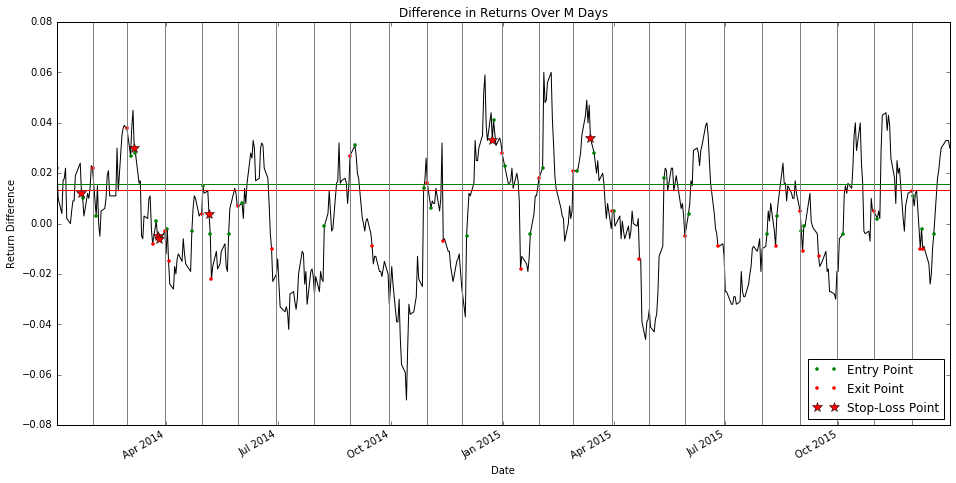

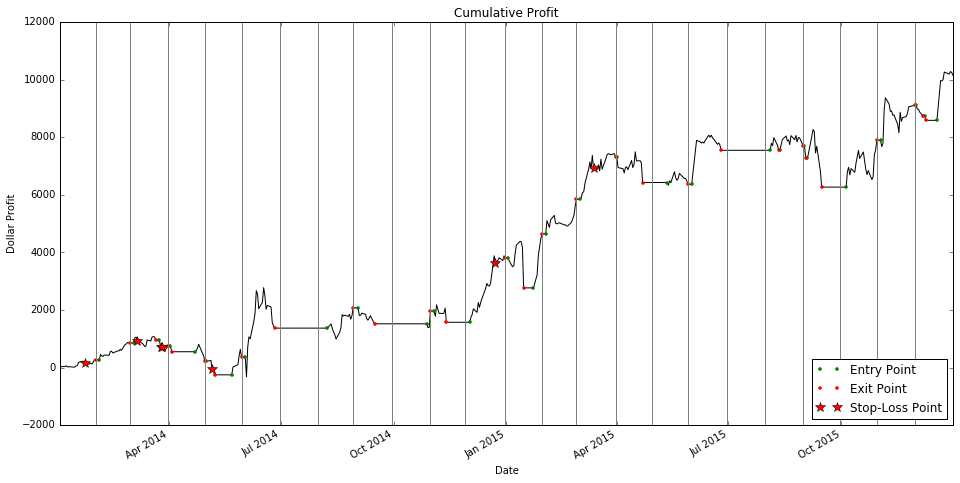

In [13]:
# plot DeltaM with entry and exit points
plt.figure(1,figsize=(16,8))
plt.title('Difference in Returns Over M Days')
plt.ylabel('Return Difference')
df.DeltaM.plot(color='black')
plt.axhline(y=0.0013*M,color='green')
plt.axhline(y=0.0011*M,color='red')
Entry_Pts = pd.DataFrame(df.Entry*df.DeltaM)
Entry_Pts = Entry_Pts[Entry_Pts != 0]
Exit_Pts = pd.DataFrame(df.Exit*df.DeltaM)
Exit_Pts = Exit_Pts[Exit_Pts != 0]
Stop_Pts = pd.DataFrame(df.Stop*df.DeltaM)
Stop_Pts = Stop_Pts[Stop_Pts != 0]
p1, = plt.plot(Entry_Pts,'g.')
p2, = plt.plot(Exit_Pts,'r.')
p3, = plt.plot(Stop_Pts,'r*',ms=10)
for i in range(0,len(df)):
    if df.EOM[i] == 1:
        plt.axvline(x=df.index[i],color='grey')
plt.legend([p1,p2,p3],['Entry Point','Exit Point','Stop-Loss Point'],loc='lower right')

# plot cumulative profit
plt.figure(2,figsize=(16,8))
plt.title('Cumulative Profit')
plt.ylabel('Dollar Profit')
df.Cum_Profit.plot(color='black')
Entry_Pts = pd.DataFrame(df.Entry*df.Cum_Profit)
Entry_Pts = Entry_Pts[Entry_Pts != 0]
Exit_Pts = pd.DataFrame(df.Exit*df.Cum_Profit)
Exit_Pts = Exit_Pts[Exit_Pts != 0]
Stop_Pts = pd.DataFrame(df.Stop*df.Cum_Profit)
Stop_Pts = Stop_Pts[Stop_Pts != 0]
p1, = plt.plot(Entry_Pts,'g.')
p2, = plt.plot(Exit_Pts,'r.')
p3, = plt.plot(Stop_Pts,'r*',ms=10)
for i in range(0,len(df)):
    if df.EOM[i] == 1:
        plt.axvline(x=df.index[i],color='grey')
plt.legend([p1,p2,p3],['Entry Point','Exit Point','Stop-Loss Point'],loc='lower right')

Finally, let's do some analysis on the strategy.  In particular, we look at how varying the parameters affects the absolute profitability of the strategy.  Since there are 4 parameter inputs (and we aren't doing a sophisticated optimization), I have decided to look at 'slices' of the strategy: varying M, varying the width (or difference) of G and J, varying the level (or placement) of G and J, and varying s.  Note that I am purposefully working with G and J (the daily barriers) instead of g and j (the M day barriers), because it makes the anaylsis more robust.  

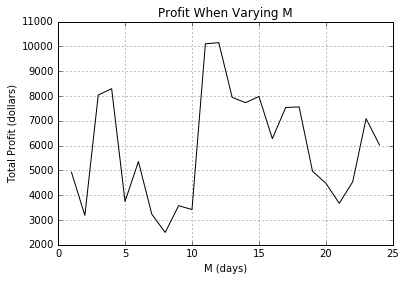

In [14]:
############################################################################
#4 ANALYSIS
############################################################################

# check overall profit when varying M. need to make j g and s functions of M
Perform_M = pd.DataFrame(columns = ['M','Cum_Profit'])
for M in range(1,25):
  df = strat(M,-0.0004*M,-0.0006*M,0.0001,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_M = Perform_M.append(pd.DataFrame([[M,df.Cum_Profit[-1]]],columns=['M','Cum_Profit']),
      ignore_index=True)
plt.figure(3)
plt.plot(Perform_M.M,Perform_M.Cum_Profit,color='black') # M=12 looks optimal
plt.title('Profit When Varying M')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('M (days)')
plt.grid()

We can see above that the most profitable range of M for G = -0.0004, J = -0.0006 and s = 0.0001 is 11 to 12.  This strategy appears to work well in general for M at the 3 to 4 day mark or 11 to 15 day mark.  

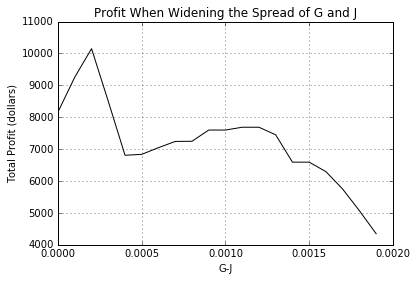

In [15]:
# check overall profit when widening the spread of g and j
Perform_W = pd.DataFrame(columns = ['W','Cum_Profit'])
M = 12
for i in range(0,20):
  i = i/20000
  G = -0.0005+i
  J = -0.0005-i
  df = strat(M,G*M,J*M,0.0001,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_W = Perform_W.append(pd.DataFrame([[G,J,G-J,df.Cum_Profit[-1]]],columns=['G','J','W','Cum_Profit']),
      ignore_index=True)
plt.figure(4)
plt.plot(Perform_W.W,Perform_W.Cum_Profit,color='black') # window of 0.0011 looks good
plt.title('Profit When Widening the Spread of G and J')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('G-J')
plt.grid()

The above plot suggests that the profitability of the strategy decreases as the spread of G and J widen.  The most profitable spread width is about 0.0002.  So G = J + 0.0002

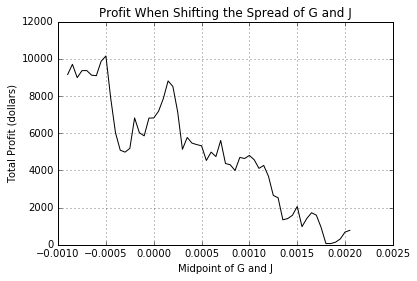

In [16]:
# check overall profit when shifting the spread of g and j
Perform_S = pd.DataFrame(columns = ['G','J','Cum_Profit'])
M = 12
for i in range(0,60):
  i = i/20000
  G = -0.0008+i
  J = -0.0010+i
  df = strat(M,G*M,J*M,0.0001,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_S = Perform_S.append(pd.DataFrame([[G,J,df.Cum_Profit[-1]]],
                                            columns=['G','J','Cum_Profit']),ignore_index=True)
plt.figure(5)
plt.plot((Perform_S.G+Perform_S.J)/2,Perform_S.Cum_Profit,color='black') # window of 0.005 looks good
plt.title('Profit When Shifting the Spread of G and J')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('Midpoint of G and J')
plt.grid()

This plot above suggests that absolute profitability decreases as the spread midpoint of G and J increases.  The most profitable point is at -0.0005; therefore setting G = -0.0004 and J = -0.0006 will be most profitable.  

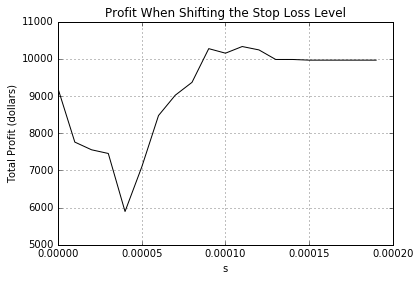

In [17]:
# check overall profit when varying the stop loss level
Perform_SL = pd.DataFrame(columns = ['s','Cum_Profit'])
M = 12
G = -0.0004
J = -0.0006
for s in range(0,20):
  s = s/100000
  df = strat(M,G*M,J*M,s,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_SL = Perform_SL.append(pd.DataFrame([[s,df.Cum_Profit[-1]]],
                                            columns=['s','Cum_Profit']),ignore_index=True)
plt.figure(6)
plt.plot(Perform_SL.s,Perform_SL.Cum_Profit,color='black') # window of 0.005 looks good
plt.title('Profit When Shifting the Stop Loss Level')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('s')
plt.grid()

Finally, this plot shows that the stop loss does not come into effect for this data past s = 0.00013.  A low stop loss seems to 'catch' the trade to much and exit too often. Higher stop loss levels seem to be more profitable in analysis, but should also be set based on the investor's risk appetite.   

Overall, I found the most profitable trading strategy to be where M=12, G=-0.0004(g=-0.0048), J = -0.0006(g=-0.0050), and s=0.0001.  The barrier levels are extremely close, and one could even argue that g=j is also a good strategy.  I think that once trading costs are introduced, the spread would widen more to minimize trade frequency (higher trade frequencies would be penalized).  